In [ ]:
!pip install tensorflow opencv-python matplotlib
!pip install opencv-python-headless
from IPython.display import clear_output
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

#Plot
from matplotlib import pyplot as plt

#Bounding boxes
import numpy as np
import tensorflow_hub as hub
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
#from six.moves.urllib.request import urlopen
from urllib.request import urlopen
#from six import BytesIO
from io import BytesIO
import time #for inference time
import os
import cv2
import imghdr


clear_output()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
IMAGE_PATH ='/content/drive/MyDrive/DATASET4'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

for image_class in os.listdir(IMAGE_PATH):
  for image in os.listdir(os.path.join(IMAGE_PATH, image_class)):
    image_path = os.path.join(IMAGE_PATH, image_class, image)
    try:
      img = cv2.imread(image_path)
      tip = imghdr.what(image_path)
      if tip not in image_exst:
        print('image not in ext list {}'.format(image_path))
        os.remove(image_path)
    except Exception as e:
        print('issue with image {}'.format(image_path))

clear_output()

In [ ]:
train_datagen = ImageDataGenerator(
    #rescale=1./255,
    #shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    #keep_aspect_ratio=True,
    validation_split=0.33
    )
IMG_SIZE=(224, 224)

train_generator = train_datagen.flow_from_directory(
    IMAGE_PATH,
    target_size=IMG_SIZE,
    batch_size=32,
    subset='training') # set as training data
class_names = train_generator.class_indices
valid_generator = train_datagen.flow_from_directory(
    IMAGE_PATH, # same directory as training data
    target_size=IMG_SIZE,
    batch_size=16,
    subset='validation')

Found 952 images belonging to 16 classes.
Found 461 images belonging to 16 classes.


In [ ]:
base_model = MobileNetV3Small(weights='imagenet', include_top=True)

x = base_model.output
#x = GlobalAveragePooling2D()(x)
#x = Dense(512, activation='relu')(x)
#x = Dense(256, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
preds = Dense(len(class_names), activation='softmax')(x)
print(preds)
model = Model(inputs=base_model.input,outputs=preds)
#model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='dense_7/Softmax:0', description="created by layer 'dense_7'")


In [ ]:
initial_learning_rate = 0.001
'''
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100, decay_rate=0.96, staircase=True
)
'''
epochs=10
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(train_generator, validation_data=valid_generator, epochs=epochs)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


30/30 [==============================] - 129s 4s/step - loss: 0.9062 - accuracy: 0.7437 - val_loss: 2.4236 - val_accuracy: 0.4751
Epoch 2/10
30/30 [==============================] - 90s 3s/step - loss: 0.9379 - accuracy: 0.7532 - val_loss: 2.2154 - val_accuracy: 0.5011
Epoch 3/10
30/30 [==============================] - 91s 3s/step - loss: 0.9514 - accuracy: 0.7426 - val_loss: 2.7240 - val_accuracy: 0.4208
Epoch 4/10
30/30 [==============================] - 110s 4s/step - loss: 0.8525 - accuracy: 0.7637 - val_loss: 2.8599 - val_accuracy: 0.3579
Epoch 5/10
30/30 [==============================] - 109s 4s/step - loss: 0.8522 - accuracy: 0.7731 - val_loss: 2.1999 - val_accuracy: 0.4989
Epoch 6/10
30/30 [==============================] - 92s 3s/step - loss: 0.8263 - accuracy: 0.7553 - val_loss: 2.1793 - val_accuracy: 0.4902
Epoch 7/10
30/30 [==============================] - 109s 4s/step - loss: 0.8018 - accuracy: 0.8046 - val_loss: 2.4717 - val_accuracy: 0.4729
Epoch 8/10
30/30 [=========

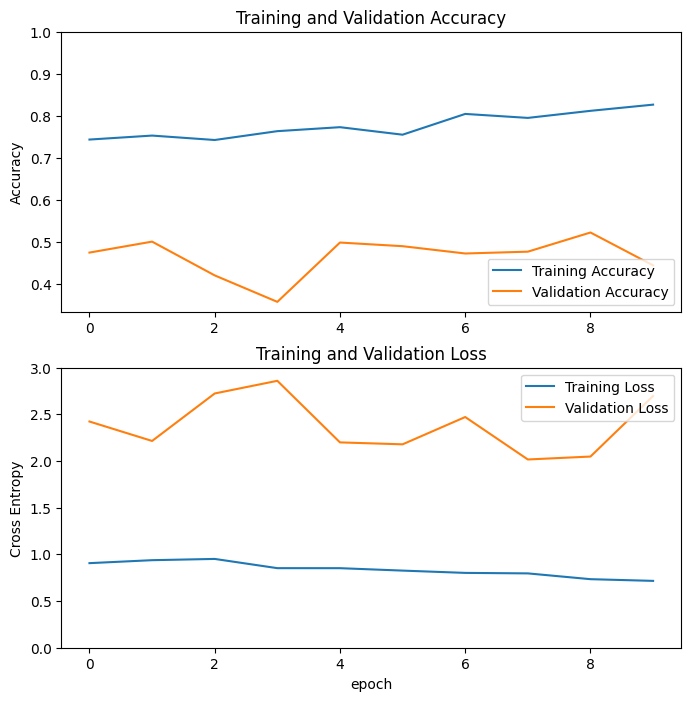

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/modello_definitivo')


In [ ]:
model1 = tf.keras.models.load_model('/content/drive/MyDrive/modello_definitivo')

# SLIDING WINDOWS + IMAGE PYRAMIDS FUNCTIONS


In [ ]:
import imutils
from google.colab.patches import cv2_imshow

In [ ]:
from imutils.object_detection import non_max_suppression
import cv2
import time
import numpy as np
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [ ]:
def sliding_window(image, step, ws):
    # slide a window across the image
    for y in range(0, image.shape[0]-ws[1], step):
        for x in range(0, image.shape[1]-ws[0], step):
            # yield the current window
            yield (x, y, image[y:y+ws[1], x:x+ws[0]])

def image_pyramid(image, scale=1.5, minSize=(224, 224)):
    # yield the original image
    yield image

    # keep looping over the image pyramid
    while True:
        # compute the dimensions of the next image in the pyramid
        w = int(image.shape[1]/scale)
        image = imutils.resize(image, width=w)

        # if the resized image does not meet the supplied mininum size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
           break

        # yield the next image in the pyramid
        yield image

In [ ]:
def classify_batch(model, batchROIs, batchLocs, labels, minProb=0.5, top=10, dims=(224,224)):
    # pass our batch ROIs through our network and decode the predictions
    preds = model.predict(batchROIs)

    P = []

    chiavi = list(class_names.keys())
    for i in range(BATCH_SIZE):
      P_tmp = {}
      for j in range(len(class_names)):
        P_tmp[chiavi[j]] = preds[i][j]
      P.append(P_tmp)

    # loop over the decoded predictions
    i=0
    count = 0
    for i in P:
      for (k,v) in i.items() :
        # filter out weak detections by ensuring the predicted probability is greater than the minimum probability
        if v > minProb:
          # grab the coordinates of the sliding window for prediction and construct the bounding box
          (pX, pY) = batchLocs[count]
          box = (pX, pY, pX+dims[0], pY+dims[1])
          # grab the list of predictions for the label and add the bounding box + probability to the list
          L = labels.get(k, [])
          L.append((box, v))
          labels[k] = L
      count = count + 1

    return labels

In [ ]:
image_path1 = "/content/drive/MyDrive/foto_test.jpg"
#image_path1 = "/content/drive/MyDrive/DATASET2/knife/000000000089.jpg"
#image_path1 = "/content/drive/MyDrive/DATASET2/apple/000000017629.jpg"

In [ ]:
INPUT_SIZE = (350, 350)
PYR_SCALE = 1.5
WIN_STEP = 16
ROI_SIZE = (224, 224)
BATCH_SIZE = 64
min_confidence = 0.5
visualize_debug = -1

In [ ]:
labels = {}

# load the input image from disk and grab its dimensions
orig = cv2.imread(image_path1)
(h,w) = orig.shape[:2]

# resize the input image to be a square
resized = cv2.resize(orig, INPUT_SIZE, interpolation=cv2.INTER_CUBIC)

# initialize the batch ROIs and (x,y) coordinates
batchROIs = None
batchLocs = []

# start the timer
print("[INFO] detecting objects...")
start = time.time()

# loop over the image pyramid
for image in image_pyramid(resized, scale=PYR_SCALE, minSize=ROI_SIZE):
    # loop over the sliding window locations
    for (x,y,roi) in sliding_window(resized, WIN_STEP, ROI_SIZE):
        # take the ROI and pre_process it so we can later classify the region with Keras
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)
        roi = preprocess_input(roi)

        if batchROIs is None:
            batchROIs = roi
        else:
            batchROIs = np.vstack([batchROIs, roi])
        batchLocs.append((x,y))

        # check to see if our batch is full
        if len(batchROIs) == BATCH_SIZE:
            # classify the batch, then reset the batch ROIs
            # and (x,y)-coordinates
            labels = classify_batch(model, batchROIs, batchLocs, labels)
            batchROIs = None
            batchLocs = []

# check to see if there are any remaining ROIs that still need to be classifier
if batchROIs is not None:
    labels = classify_batch(model, batchROIs, batchLocs, labels)

# show how long the detection process took
end = time.time()
print("[INFO] detections took {:.4f} seconds".format(end-start))


for k in labels.keys():
    # clone the input image so we can draw on it
    clone = resized.copy()
    # loop over all bounding boxes for the label and draw them on the image
    for(box, prob) in labels[k]:
        (xA, yA, xB, yB) = box
        cv2.rectangle(clone, (xA, yA), (xB, yB), (0, 255, 0), 2)

    # show the image *without* apply non-maxima suppression
    cv2_imshow( clone)
    clone = resized.copy()

    # grab the bounding boxes and associated probabilities for each detection,
    # then apply non-maxima suppression to suppress weaker, overlapping detections
    boxes = np.array([p[0] for p in labels[k]])
    proba = np.array([p[1] for p in labels[k]])
    boxes = non_max_suppression(boxes, proba)

    # loop over the bounding boxes again, this time only drawing the ones that were not supressed
    for (xA, yA, xB, yB) in boxes:
        cv2.rectangle(clone, (xA, yA), (xB, yB), (0, 0, 255), 2)

    # show the output image
    print("[INFO] {}: {}".format(k, len(boxes)))
    cv2_imshow(clone)
    cv2.waitKey(0)

In [ ]:
# Converting a tf.Keras model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(model1)
model = converter.convert()

# Save the model.
with open('model_tflite', 'wb') as f:
  f.write(model)